###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [1]:
%matplotlib inline

import numpy               as np
import matplotlib.pyplot   as plt
from GDa.spectral_analysis import spectral, spectral_analysis
from GDa.session           import session

The class __spectral_analysis__ inherits from a more general class named __spectral__. Let's start by using the __spectral__ class:

In [2]:
spec = spectral()

To use the object __spec__ first we read a sample LFP signal:

In [3]:
data = np.load('raw_lfp/lucy_session01_150304.npy',allow_pickle=True).item()['data']
N    = data.shape[2]   # Number of time points 
fs   = 1000            # Sampling frequency  [Hz]

Next, we will select a random LFP signal in data:

In [4]:
lfp   = data[np.random.randint(0, data.shape[0]),np.random.randint(0, data.shape[1]),:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
time = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

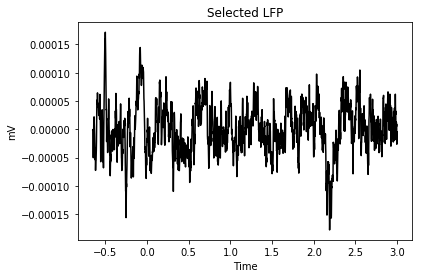

In [5]:
# Plotting the signal
plt.plot(time, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the signal with the function __filter__ in __spectral__, let's filter it on the alpha band (8-12 Hz):

In [6]:
lfp_filterd = spec.filter(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

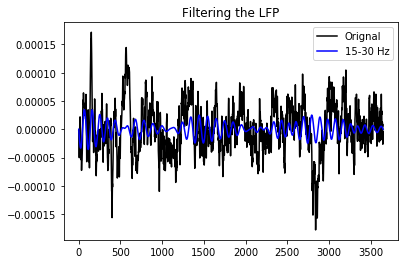

In [7]:
plt.plot(lfp, 'k')
plt.plot(lfp_filterd, 'b')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '15-30 Hz'])

We can compute the spectogram of the signal using the function __spectogram__, it is possible to use morlet or multitaper transforms.



In [8]:
fmax = 10
W_morlet     = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, 
                               freqs = np.arange(6,60,.1),
                               method = 'morlet', n_jobs = -1)
W_multitaper = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, 
                               freqs = np.arange(6,60,.1), 
                               method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.5s finished


Next, we can visualize the result:

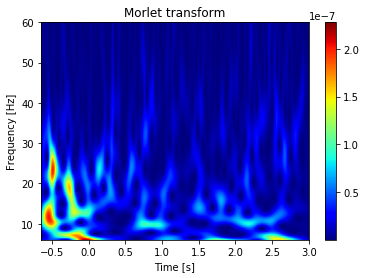

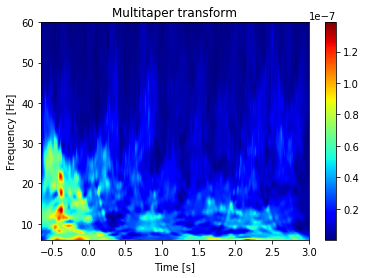

In [9]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(W_morlet), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(W_multitaper), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

We can measure also the instantaneous power with the function __instantaneous_power__, let's see, for instance how the power in alpha band change through time:

In [10]:
P = spec.instantaneous_power(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib64/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Power')

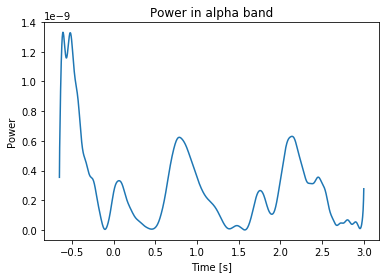

In [11]:
plt.title('Power in alpha band')
plt.plot(time, P)
plt.xlabel('Time [s]')
plt.ylabel('Power')

For all functions above we can use only one signal as input or for a matrix with dimensions [N_trials, N_channels, time].

The __spectral_analysis__ class inherits the functions from __spectral__ however it is more focused on appling then efficiently to the LFP data. We can instatiate the __spectral_analysis__ class by either passing an session object to it, or by reading the data file saved by the session object (see notebook 1).

In [12]:
# 1. INSTATIATING SPECTRAL_ANALYSIS USING A SESSION OBJECT

ses = session(raw_path = 'GrayLab/', monkey = 'lucy', stype = 'samplecor', date = '150128', 
              session = 1, evt_dt = [-0.65,3.00])

ses.read_session_info()
ses.read_lfp_data()

spec = spectral_analysis(session = ses, path = None)

In [13]:
# 2. INSTATIATING SPECTRAL_ANALYSIS USING THE DATA FILE FROM SESSION

spec = spectral_analysis(session = None, path = 'raw_lfp/lucy_session01_150304.npy')

We can do all the operations we did with the __spectral__ object easily now. The operations are done by giving the trial, and channels number in which they should be performed. Let's starting by filtering a random signal in the alpha band.

In [14]:
lfp_filterd = spec.filter(trial = np.random.randint(0, data.shape[0]), 
                          index_channel = np.random.randint(0, data.shape[1]),
                          apply_to_all = False,
                          f_low = 8, f_high = 12, n_jobs = 1)

Filtering the signal

Text(0, 0.5, 'mV')

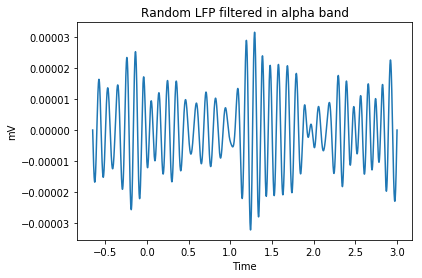

In [15]:
plt.plot(time, lfp_filterd )
plt.title('Random LFP filtered in alpha band')
plt.xlabel('Time')
plt.ylabel('mV')

Computing spectogram

In [16]:
W = spec.spectogram(trial = np.random.randint(0, data.shape[0]), 
                    index_channel = np.random.randint(0, data.shape[1]), 
                    apply_to_all = False,
                    freqs = np.arange(6,60,.01), method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    5.3s finished


Text(0.5, 0, 'Time [s]')

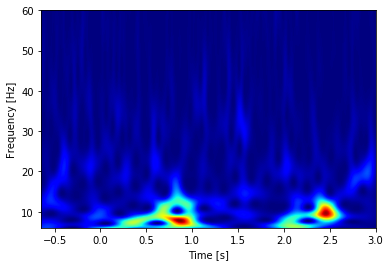

In [17]:
plt.imshow(np.squeeze(W), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

Instantaneous power spectrum

In [18]:
P = spec.instantaneous_power(trial = np.random.randint(0, data.shape[0]), 
          index_channel =  np.random.randint(0, data.shape[1]), 
          f_low = 8, f_high = 12, n_jobs = -1)

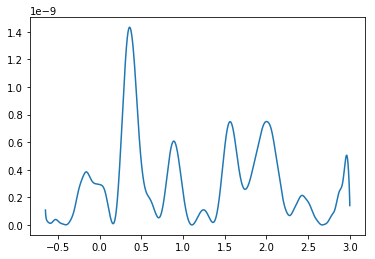

In [19]:
plt.plot(time, P)

Computing pairwise coherence, in the function pairwie coherence *fc* is the frenquency center used in the band-pass filter, *df* the width of the filter (i.e., [fc-df, fc+df]), and dt is the length of the convolution window applyied to the instantaneous power spectrum computed.

In [59]:
coh = spec.pairwise_coherence(trial = 0, 
                              index_pair =  0,
                              dt = 250, fc = np.arange(6, 62, 1), 
                              df = 4, n_jobs = -1, save_to_file = False)

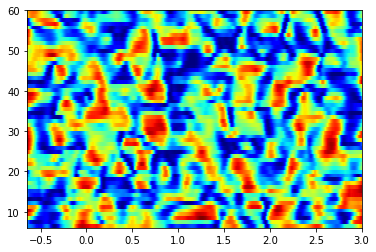

In [60]:
plt.imshow(np.real(coh.T), aspect = 'auto', cmap='jet', origin = 'lower', extent = [-0.65, 3.00, 6, 60])

In [25]:
ch1, ch2 = spec.pairs[0, 0], spec.pairs[0, 1]

In [27]:
s1, s2 = spec.data[0, ch1,:], spec.data[0, ch2,:]

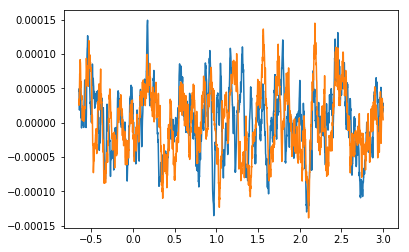

In [29]:
plt.plot(time, s1)
plt.plot(time, s2)

In [86]:
s1f  = spec.filter(trial = 0, index_channel = ch1, f_low = 8, f_high = 12, n_jobs = -1)
s2f  = spec.filter(trial = 0, index_channel = ch2, f_low = 8, f_high = 12, n_jobs = -1)

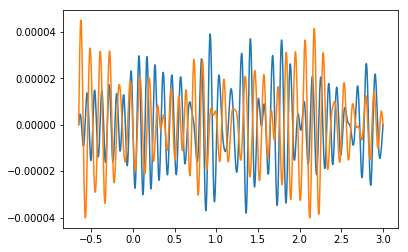

In [87]:
plt.plot(time, s1f)
plt.plot(time, s2f)

In [91]:
import scipy.signal
Sx1 = scipy.signal.hilbert(s1f)
Sy1 = scipy.signal.hilbert(s2f)
Sxy = np.multiply( Sx1, np.conj(Sy1) )
Sxx = np.multiply( Sx1, np.conj(Sx1) )
Syy = np.multiply( Sy1, np.conj(Sy1) )

coh = Sxy*np.conj(Sxy) / (Sxx*Syy)

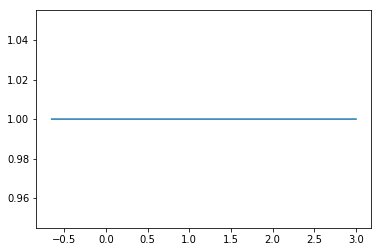

In [92]:
plt.plot(time, coh.real)

In [55]:
import scipy.signal 
f, C = scipy.signal.coherence(s1, s2, fs=1000)

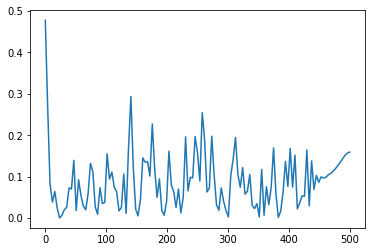

In [56]:
plt.plot(f, C)

In [109]:
S = (1+1j)*np.zeros([3, spec.data.shape[2]])
dt = 1000
# Low and high frequency
f_low, f_high = 30, 40
# Channel 1 and 2 indexis
ch1, ch2 = spec.pairs[0, 0], spec.pairs[0, 1]
# Filtering each signal
sig1f  = spec.filter(trial = 0, index_channel = ch1,
                     f_low = f_low, f_high = f_high, n_jobs = -1)
sig2f  = spec.filter(trial = 0, index_channel = ch2, 
                     f_low = f_low, f_high = f_high, n_jobs = -1)
Sx     = scipy.signal.hilbert(sig1f)
Sy     = scipy.signal.hilbert(sig2f)
# Computing instantaneous power spectrum
S[0, :] = np.multiply( Sx, np.conj(Sy) )
S[1, :] = np.multiply( Sx, np.conj(Sx) )
S[2, :] = np.multiply( Sy, np.conj(Sy) )
#Sm = S.T
Sm = scipy.signal.convolve2d(S.T, np.ones([dt, 1]), mode='same')
coh = ( Sm[:, 0]*np.conj(Sm[:, 0]) / (Sm[:, 1]*Sm[:,2]) ).real

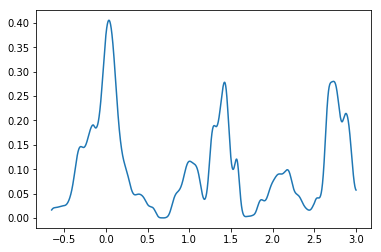

In [114]:
plt.plot(time, coh)

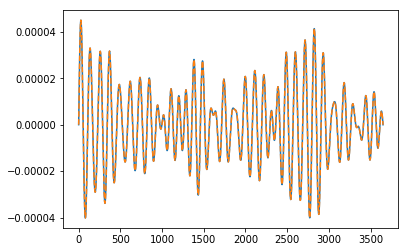

In [80]:
plt.plot(Sy)
plt.plot(Sy1, '--')

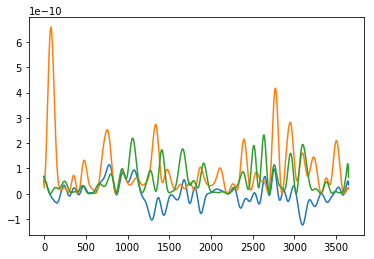

In [107]:
plt.plot(S[0, :])
plt.plot(S[1, :])
plt.plot(S[2, :])